In [1]:
import qif
import numpy as np
import pandas as pd

from causalgraphicalmodels import StructuralCausalModel, CausalGraphicalModel
from tqdm.notebook import tqdm
from scipy.stats import entropy
from multiprocessing import Pool

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

## Channels

In [2]:
# Support functions
def bernoulli(p, size=None):
    """p = P(x=1)"""
    return np.random.binomial(n=1, p=p, size=size)


def _z_channel(x, flip):
    if x == 0:
        return 0
    else:
        return bernoulli(1-flip)
    

def _direct_channel(x):
    return x


def _symmetric_channel(x, flip):
    if x == 0:
        return bernoulli(flip)
    else:
        return bernoulli(1 - flip)
    
    
def _xor_channel(x1, x2):
    if x1 == x2:
        return bernoulli(0)
    else:
        return bernoulli(1)
    

def _pxor_channel(x1, x2, flip):
    if x1 == x2:
        return bernoulli(flip)
    else:
        return bernoulli(1 - flip)
    

def _and_channel(x1, x2):
    if x1 == x2 == 1:
        return bernoulli(1)
    else:
        return bernoulli(0)
    

def _pand_channel(x1, x2, flip):
    if x1 == x2 == 1:
        return bernoulli(1 - flip)
    else:
        return bernoulli(flip)
    

def _or_channel(x1, x2):
    if x1 == x2 == 0:
        return bernoulli(0)
    else:
        return bernoulli(1)
    

def _por_channel(x1, x2, flip):
    if x1 == x2 == 0:
        return bernoulli(flip)
    else:
        return bernoulli(1 - flip)
    
    
def joint_distribution(df, x, y):
    joint_dist = df.groupby([x, y]).size().unstack()
    joint_dist.columns = joint_dist.columns.get_level_values(0)
    joint_dist = joint_dist.div(joint_dist.sum().sum())
    return joint_dist.fillna(0)

In [3]:
# Graph function
def one_variable_channel(x, flip=0.5, name='z'):
    if name == 'z':
        return _z_channel(x, flip)
    elif name == 'direct':
        return _direct_channel(x)
    elif name == 'symmetric':
        return _symmetric_channel(x, flip)
    else:
        raise NameError('Function not valid')
    
    
def two_variables_channel(x1, x2, flip=0.5, name='xor'):
    if name == 'xor':
        return _xor_channel(x1, x2)
    elif name == 'pxor':
        return _pxor_channel(x1, x2, flip)
    elif name == 'and':
        return _and_channel(x1, x2)
    elif name == 'pand':
        return _pand_channel(x1, x2, flip)
    elif name == 'or':
        return _or_channel(x1, x2)
    elif name == 'por':
        return _por_channel(x1, x2, flip)
    else:
        raise NameError('Function not valid')

In [4]:
# Entropy functions
def guessing_entropy(l):
    """ Return the Shannon entropy of random variable with probability vector l"""
    tmp = l.sort_values(ascending=False)
    return sum([p*i for (i,p) in enumerate(l)]) + 1


def shannon_entropy(l):
    return entropy(l, base=2)


def joint_shannon_entropy(joint):
    return shannon_entropy(joint.values.flatten())


def conditional_shannon_entropy(joint, axis=1):
    X = joint.sum(axis=axis)
    Y_given_X = joint.div(X, axis=1)
    ent = 0
    for x in X.index:
        if axis == 1:
            tmp = Y_given_X.loc[x]
        else:
            tmp = Y_given_X[x]
        ent += X.loc[x] * entropy(tmp, base=2)   
    return ent


def mutual_information(joint, axis=0):
    Y = joint.sum(axis=axis)
    return shannon_entropy(Y) - conditional_shannon_entropy(joint, axis=1-axis)

In [5]:
# Compute attributes
def test_suite(df):
    data = {}
    joint = joint_distribution(df, x='X', y='Y')
    data['shannon_entropy_X'] = shannon_entropy(joint.sum(axis=1))
    data['shannon_entropy_Y'] = shannon_entropy(joint.sum(axis=0))
    data['joint_shannon_entropy'] = joint_shannon_entropy(joint)
    data['conditional_shannon_entropy_X|Y'] = conditional_shannon_entropy(joint, axis=0)
    data['conditional_shannon_entropy_Y|X'] = conditional_shannon_entropy(joint, axis=1)
    data['mutual_information'] = mutual_information(joint, axis=0)
    data['guessing_entropy_X'] = guessing_entropy(joint.sum(axis=1))
    data['guessing_entropy_Y'] = guessing_entropy(joint.sum(axis=0))
    
    bayes = qif.BayesLeakage(df)
    data['mult_avg_dir_flow'], data['mult_avg_rev_flow'] = bayes.compute_flows(x='X', y='Y')
    data['mult_max_dir_flow'], data['mult_max_rev_flow'] = bayes.compute_flows(x='X', y='Y', vulnerability_type='max')
    data['addt_avg_dir_flow'], data['addt_avg_rev_flow'] = bayes.compute_flows(x='X', y='Y', leakage_type='additive')
    data['addt_max_dir_flow'], data['addt_max_rev_flow'] = bayes.compute_flows(x='X', y='Y', leakage_type='additive', vulnerability_type='max')
    return data

In [6]:
# Setup
one_var_list = ['z', 'direct', 'symmetric']
two_var_list = ['xor', 'pxor', 'and', 'pand', 'or', 'por']
dist = [0, 0.25, 0.5, 0.75, 1]
n_runs = 30

# Aliases
choice = np.random.choice

## SCMs

### Basic causal

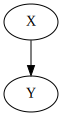

In [7]:
basic_causal = StructuralCausalModel({
    "X": lambda    n_samples: np.random.binomial(n=1, p=p, size=n_samples),
    "Y": lambda X, n_samples: np.array(list(map(one_variable_channel, X, np.array([p_flip] * n_samples), np.array([func] * n_samples)))),
})

basic_causal.cgm.draw()

In [ ]:
basic_causal_flows = []
for p in dist:
    for p_flip in dist:
        for func in one_var_list:
            for _ in range(n_runs):
                df = basic_causal.sample(10000)
                basic_causal_dict = test_suite(df)
                basic_causal_dict['p'] = p
                basic_causal_dict['p_flip'] = p_flip
                basic_causal_dict['func'] = func
                basic_causal_dict['name'] = 'basic_causal'
                basic_causal_flows.append(basic_causal_dict)

In [9]:
basic_causal_df = pd.DataFrame(basic_causal_flows)

### Basic anticausal

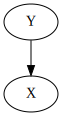

In [10]:
basic_anticausal = StructuralCausalModel({
    "Y": lambda    n_samples: np.random.binomial(n=1, p=p, size=n_samples),
    "X": lambda Y, n_samples: np.array(list(map(one_variable_channel, Y, np.array([p_flip] * n_samples), np.array([func] * n_samples)))),
})

basic_anticausal.cgm.draw()

In [11]:
basic_anticausal_flows = []
for p in dist:
    for p_flip in dist:
        for func in one_var_list:
            for _ in range(n_runs):
                df = basic_anticausal.sample(10000)
                basic_anticausal_dict = test_suite(df)
                basic_anticausal_dict['p'] = p
                basic_anticausal_dict['p_flip'] = p_flip
                basic_anticausal_dict['func'] = func
                basic_anticausal_dict['name'] = 'basic_anticausal'
                basic_anticausal_flows.append(basic_anticausal_dict)

In [12]:
basic_anticausal_df = pd.DataFrame(basic_anticausal_flows)

In [13]:
df = pd.concat([basic_causal_df, basic_anticausal_df])

In [14]:
df.to_parquet("data/df_mqecc.parquet", engine="pyarrow")

### Read saved data

In [9]:
df = pd.read_parquet("data/df_mqecc.parquet", engine='pyarrow')

In [10]:
data = df.copy()

In [11]:
cols_to_drop = [x for x in df.columns if 'entropy' in x]
df.drop(columns=cols_to_drop, inplace=True)
df.drop(columns=['mutual_information'], inplace=True)

## Fatorial 2k

In [17]:
fat_2k = df.copy()

In [18]:
fat_2k.query("p == 0.25 or p == 0.75", inplace=True)
fat_2k.query("p_flip == 0 or p_flip == 0.5", inplace=True)
fat_2k.query("func == 'z' or func == 'symmetric'", inplace=True)

In [19]:
fat_2k['i'] = 1
fat_2k['a'] = fat_2k['p'].replace({0.25:-1, 0.75:1})
fat_2k['b'] = fat_2k['p_flip'].replace({0:-1, 0.5:1})
fat_2k['c'] = fat_2k['func'].replace({'z':1, 'symmetric':-1})
fat_2k['ab'] = fat_2k['a'] * fat_2k['b']
fat_2k['ac'] = fat_2k['a'] * fat_2k['c']
fat_2k['bc'] = fat_2k['b'] * fat_2k['c']
fat_2k['abc'] = fat_2k['a'] * fat_2k['b'] * fat_2k['c']

fat_2k['mult_avg_flow'] = fat_2k['mult_max_dir_flow'] - fat_2k['mult_avg_rev_flow']
fat_2k['mult_max_flow'] = fat_2k['mult_max_dir_flow'] - fat_2k['mult_max_rev_flow']
fat_2k['addt_avg_flow'] = fat_2k['addt_avg_dir_flow'] - fat_2k['addt_avg_rev_flow']
fat_2k['addt_max_flow'] = fat_2k['addt_max_dir_flow'] - fat_2k['addt_max_rev_flow']

In [20]:
fat_2k = fat_2k.iloc[:, 8:]

In [21]:
factors = ['i', 'a', 'b', 'c', 'ab', 'ac', 'bc', 'abc']
metric = 'mult_avg_flow'

In [22]:
tmp = fat_2k[factors + [metric]].copy()
tmp.reset_index(drop=True, inplace=True)

In [23]:
effects = tmp[factors].values.T.dot(tmp[metric].values)/16
sst_v = 8 * (effects[1:]**2)
sst = sst_v/np.sum(sst_v)

tmp.loc[len(tmp)] = np.append(effects, [np.nan])

In [24]:
tmp.dropna(inplace=True)

In [25]:
tmp

,i,a,b,c,ab,ac,bc,abc,mult_avg_flow
0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,0.000000
1,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,0.000000
2,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,0.000000
3,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,0.000000
4,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...
475,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.025675
476,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.029211
477,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.017490
478,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.006332


In [26]:
import statsmodels.formula.api as smf

In [27]:
mod = smf.ols(formula='mult_avg_flow ~ a + b + c + ab + ac + bc + abc', data=tmp)

In [28]:
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          mult_avg_flow   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     255.2
Date:                Sat, 07 Nov 2020   Prob (F-statistic):          5.07e-156
Time:                        18:31:04   Log-Likelihood:                 536.01
No. Observations:                 480   AIC:                            -1056.
Df Residuals:                     472   BIC:                            -1023.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0789      0.004     21.637      0.0

In [29]:
sst

array([0.06422176, 0.26202893, 0.2418178 , 0.06422176, 0.06294597,
       0.2418178 , 0.06294597])

In [30]:
tmp

,i,a,b,c,ab,ac,bc,abc,mult_avg_flow
0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,0.000000
1,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,0.000000
2,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,0.000000
3,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,0.000000
4,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...
475,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.025675
476,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.029211
477,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.017490
478,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.006332


## ANOVA

In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [14]:
def discrete_flow(f):
    if f > 0:
        return "positive"
    elif f < 0:
        return "negative"
    else:
        return "zero"

In [15]:
df.query("p_flip != 1 and p_flip != 0.75", inplace=True)
df['p'] = df['p'].replace({0:'zero', 0.25:'low', 0.5:'medium', 0.75:'high', 1:'one'})
df['p_flip'] = df['p_flip'].replace({0:'low', 0.25:'medium', 0.5:'high'})
df['y_true'] = df['name'].replace({'basic_causal':1, 'basic_anticausal':0})
df['mult_avg_flow'] = df['mult_max_dir_flow'] - df['mult_avg_rev_flow']
df['mult_max_flow'] = df['mult_max_dir_flow'] - df['mult_max_rev_flow']
df['addt_avg_flow'] = df['addt_avg_dir_flow'] - df['addt_avg_rev_flow']
df['addt_max_flow'] = df['addt_max_dir_flow'] - df['addt_max_rev_flow']
df['y_pred'] = (df['mult_avg_flow'] > 0) * 1
df['flow'] = df['mult_avg_flow'].apply(discrete_flow)
df.reset_index(drop=True, inplace=True)

In [16]:
lm = ols('y_true ~ (C(p)*C(func)*C(p_flip))+C(flow)', data=df).fit()

In [39]:
table = sm.stats.anova_lm(lm, typ=1)

In [38]:
display(table.round(4))

,sum_sq,df,F,PR(>F)
C(p),0.1086,4.0,0.1073,0.9800
C(func),1.7369,2.0,3.4308,0.0325
C(p_flip),0.0561,2.0,0.1109,0.8950
C(flow),3.2462,2.0,6.4121,0.0017
C(p):C(func),0.3940,8.0,0.1946,0.9917
C(p):C(p_flip),0.1316,8.0,0.0650,0.9998
C(func):C(p_flip),0.1323,4.0,0.1307,0.9712
C(p):C(func):C(p_flip),0.2258,16.0,0.0557,1.0000
Residual,671.7961,2654.0,NaN,NaN


## Classificador

### Train test spit

In [85]:
def classification_report_function(clf, xtest, ytest):
    y_pred = clf.predict(xtest.drop(columns=['func', 'stratify']))
    tmp = xtest.copy()
    tmp['y_true'] = y_test
    tmp['y_pred'] = y_pred
    funcs = ['z', 'symmetric', 'direct']
    for func in funcs:
        print("----------------------- {} --------------------------".format(func))
        test = tmp.query("func == '{}'".format(func))
        print(classification_report(test['y_true'], test['y_pred'], zero_division=0))

In [86]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

In [87]:
columns = ['y_true', 'mult_avg_flow', 'mult_max_flow', 'addt_avg_flow', 'addt_max_flow', 'func']
# columns = ['y_true', 'mult_avg_dir_flow', 'mult_avg_rev_flow', 'mult_max_dir_flow', 'mult_max_rev_flow',
#            'addt_avg_dir_flow', 'addt_avg_rev_flow', 'addt_max_dir_flow', 'addt_max_rev_flow', 'func']

In [88]:
X = df[columns].copy()
X['stratify'] = X['func'] + X['y_true'].astype(str)
#X = pd.get_dummies(X, prefix=['p', 'p_flip', 'func'])

In [89]:
Y = X['y_true'].copy()
X = X.drop(columns=['y_true']).copy()

In [90]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=X['stratify'], test_size=0.2, random_state=42)
X_test_func = X_test.copy()
X_train.drop(columns=['stratify', 'func'], inplace=True)
X_test.drop(columns=['stratify', 'func'], inplace=True)

/home/felipegiori/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### SVM

In [22]:
from sklearn.svm import SVC

In [23]:
# Set the parameters by cross-validation
grid_svm = [
    {
        'kernel': ['rbf'],
        'gamma': [1e-3, 1e-4],
        'C': [1, 10, 100, 1000]
    },
    {
        'kernel': ['linear'],
        'C': [1, 10, 100, 1000]
    }
]

In [24]:
scores = ['precision', 'recall']
svm = GridSearchCV(SVC(), grid_svm, n_jobs=8, scoring='f1', cv=5)
svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=8,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             scoring='f1')

In [25]:
y_true, y_pred = y_test, svm.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.16      0.27       270
           1       0.53      0.95      0.68       270

    accuracy                           0.56       540
   macro avg       0.64      0.56      0.47       540
weighted avg       0.64      0.56      0.47       540



### XGBoost

In [94]:
import xgboost

In [95]:
grid_xgb = {
     "eta": [0.05, 0.10, 0.15, 0.20],
     "max_depth": [3, 4, 5, 6, 8, 10],
     "min_child_weight": [1, 3, 5],
     "gamma": [0.0, 0.1, 0.2, 0.3],
     "colsample_bytree": [0.3, 0.4, 0.5]
}

xgb = GridSearchCV(xgboost.XGBClassifier(), grid_xgb, n_jobs=8, scoring="f1", cv=5)
xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [96]:
y_pred = xgb.predict(X_test)

In [97]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.98      0.71       270
           1       0.92      0.24      0.38       270

    accuracy                           0.61       540
   macro avg       0.74      0.61      0.55       540
weighted avg       0.74      0.61      0.55       540



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

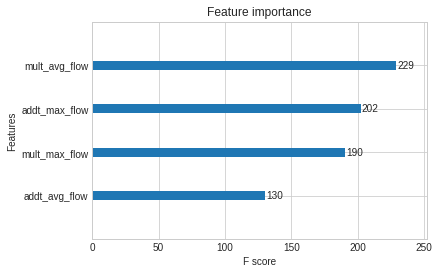

In [98]:
xgboost.plot_importance(xgb.best_estimator_)

In [99]:
classification_report_function(xgb, X_test_func, y_test)

----------------------- z --------------------------
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        90
           1       1.00      0.42      0.59        90

    accuracy                           0.71       180
   macro avg       0.82      0.71      0.68       180
weighted avg       0.82      0.71      0.68       180

----------------------- symmetric --------------------------
              precision    recall  f1-score   support

           0       0.57      0.93      0.71        90
           1       0.82      0.30      0.44        90

    accuracy                           0.62       180
   macro avg       0.69      0.62      0.57       180
weighted avg       0.69      0.62      0.57       180

----------------------- direct --------------------------
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        90
           1       0.00      0.00      0.00        90

    accura

### Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
grid_rf = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5],
    'n_estimators': [200, 400, 600, 1000]
}

In [35]:
rf = GridSearchCV(RandomForestClassifier(), grid_rf, n_jobs=8, scoring="f1", cv=5)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=8,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [200, 400, 600, 1000]},
             scoring='f1')

In [36]:
y_pred = rf.predict(X_test)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.97      0.71       270
           1       0.88      0.24      0.38       270

    accuracy                           0.60       540
   macro avg       0.72      0.60      0.54       540
weighted avg       0.72      0.60      0.54       540



In [38]:
classification_report_function(rf, X_test_func, y_test)

----------------------- z --------------------------
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        90
           1       1.00      0.42      0.59        90

    accuracy                           0.71       180
   macro avg       0.82      0.71      0.68       180
weighted avg       0.82      0.71      0.68       180

----------------------- symmetric --------------------------
              precision    recall  f1-score   support

           0       0.56      0.90      0.69        90
           1       0.75      0.30      0.43        90

    accuracy                           0.60       180
   macro avg       0.66      0.60      0.56       180
weighted avg       0.66      0.60      0.56       180

----------------------- direct --------------------------
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        90
           1       0.00      0.00      0.00        90

    accura

### Logistic Regression

In [61]:
from sklearn.linear_model import LogisticRegression

#### sklearn

In [71]:
grid_lr = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"], "max_iter":[1000]}
log_reg = GridSearchCV(LogisticRegression(), grid_lr, cv=5, scoring="f1")
log_reg.fit(X_train, y_train)

/home/felipegiori/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipegiori/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felipegiori/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/felipegiori/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/felipegiori/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:55

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'max_iter': [1000], 'penalty': ['l1', 'l2']},
             scoring='f1')

In [72]:
y_pred = log_reg.predict(X_test)

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.53      0.54       270
           1       0.55      0.58      0.56       270

    accuracy                           0.55       540
   macro avg       0.55      0.55      0.55       540
weighted avg       0.55      0.55      0.55       540



In [75]:
classification_report_function(log_reg, X_test_func, y_test)

----------------------- z --------------------------
              precision    recall  f1-score   support

           0       0.62      0.47      0.53        90
           1       0.57      0.71      0.63        90

    accuracy                           0.59       180
   macro avg       0.59      0.59      0.58       180
weighted avg       0.59      0.59      0.58       180

----------------------- symmetric --------------------------
              precision    recall  f1-score   support

           0       0.61      0.49      0.54        90
           1       0.57      0.69      0.63        90

    accuracy                           0.59       180
   macro avg       0.59      0.59      0.58       180
weighted avg       0.59      0.59      0.58       180

----------------------- direct --------------------------
              precision    recall  f1-score   support

           0       0.49      0.63      0.55        90
           1       0.48      0.33      0.39        90

    accura

#### statsmodels

In [78]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [92]:
#Z_train = StandardScaler().fit_transform(X_train)
sm_log_reg = sm.Logit(y_train, sm.add_constant(X_train)).fit()

Optimization terminated successfully.
         Current function value: 0.682886
         Iterations 5


In [93]:
sm_log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 y_true   No. Observations:                 2160
Model:                          Logit   Df Residuals:                     2155
Method:                           MLE   Df Model:                            4
Date:                Tue, 24 Nov 2020   Pseudo R-squ.:                 0.01480
Time:                        14:15:59   Log-Likelihood:                -1475.0
converged:                       True   LL-Null:                       -1497.2
Covariance Type:            nonrobust   LLR p-value:                 5.482e-09
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0069      0.046     -0.149      0.882      -0.098       0.084
mult_avg_flow     0.2433      0.439      0.554      0.580      -0.617       1.104
mult_max_flow    -2.5932      1.901     -1.364      0.173      -6.320       1.133
addt_avg_flow    -3.9866      1.606     -2.482      0.013      -7.135      -0.838
addt_max_flow    13.4414      4.159      3.232      0.001       5.290      21.593
=================================================================================
"""

## ANOVA ~ Misclassification

In [52]:
X = df[columns].copy()
X = pd.get_dummies(X, prefix=['p', 'p_flip', 'func'])
Y = X['y_true'].copy()
X = X.drop(columns=['y_true']).copy()

y_pred = clf.predict(X)

In [53]:
X['y_true'] = Y
X['y_pred'] = y_pred

In [54]:
X['val'] = (X['y_true'] == X['y_pred'])*1

In [55]:
Xs = df[columns].copy()
Xs['val'] = X['val']
Xs['y_pred'] = X['y_pred']
Xs['flow'] = Xs['mult_avg_flow'].apply(discrete_flow)

In [56]:
lm = ols('val ~ (C(p)*C(p_flip)*C(func))+C(flow)', data=Xs).fit()

In [57]:
lm = ols('y_pred ~ C(p)+C(p_flip)+C(func)+C(flow)+(C(p)*C(func))', data=Xs).fit()

In [58]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_pred   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     108.6
Date:                Sat, 07 Nov 2020   Prob (F-statistic):          5.25e-302
Time:                        18:33:34   Log-Likelihood:                -1219.3
No. Observations:                2700   AIC:                             2477.
Df Residuals:                    2681   BIC:                             2589.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.3346      0.048      7.006      0.000       0.241       0.428
C(p)[T.low]                          4.996e-15      0.040   1.24e-13      1.000      -0.079       0.079
C(p)[T.medium]                         -0.3333      0.040     -8.290      0.000      -0.412      -0.254
C(p)[T.one]                             0.3333      0.040      8.290      0.000       0.254       0.412
C(p)[T.zero]                            0.3333      0.040      8.290      0.000       0.254       0.412
C(p_flip)[T.low]                       -0.4445      0.022    -20.169      0.000      -0.488      -0.401
C(p_flip)[T.medium]                    -0.0002      0.018     -0.011      0.992      -0.036       0.035
C(func)[T.symmetric]                   -0.1595      0.045     -3.508      0.000      -0.249      -0.070
C(func)[T.z]                           -0.1440      0.045     -3.168      0.002      -0.233      -0.055
C(flow)[T.positive]                     0.2618      0.033      7.899      0.000       0.197       0.327
C(flow)[T.zero]                         0.4803      0.040     12.113      0.000       0.403       0.558
C(p)[T.low]:C(func)[T.symmetric]        0.0024      0.057      0.042      0.967      -0.109       0.114
C(p)[T.medium]:C(func)[T.symmetric]     0.2654      0.057      4.657      0.000       0.154       0.377
C(p)[T.one]:C(func)[T.symmetric]       -0.5072      0.061     -8.356      0.000      -0.626      -0.388
C(p)[T.zero]:C(func)[T.symmetric]      -0.8405      0.061    -13.848      0.000      -0.960      -0.721
C(p)[T.low]:C(func)[T.z]                0.3770      0.057      6.599      0.000       0.265       0.489
C(p)[T.medium]:C(func)[T.z]             0.7103      0.057     12.433      0.000       0.598       0.822
C(p)[T.one]:C(func)[T.z]               -0.5226      0.061     -8.612      0.000      -0.642      -0.404
C(p)[T.zero]:C(func)[T.z]              -0.5226      0.061     -8.612      0.000      -0.642      -0.404
==============================================================================
Omnibus:                      591.703   Durbin-Watson:                   0.185
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.575
Skew:                           0.309   Prob(JB):                     1.22e-33
Kurtosis:                       2.018   Cond. No.                         28.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
table = sm.stats.anova_lm(lm, typ=2)

In [60]:
display(table)

,sum_sq,df,F,PR(>F)
C(p),10.907439,4.0,18.741695,3.297788e-15
C(p_flip),71.111127,2.0,244.373241,3.224769e-98
C(func),91.827649,2.0,315.565525,8.467576e-124
C(flow),21.445244,2.0,73.696537,6.963443e-32
C(p):C(func),100.203509,8.0,86.087288,2.734068e-127
Residual,390.077348,2681.0,NaN,NaN


In [62]:
X_test_tmp = X_test.copy()
y_pred = clf.predict(X_test)
X_test_tmp['y_true'] = y_test
X_test_tmp['y_pred'] = y_pred

In [63]:
funcs = ['z', 'symmetric', 'direct']
for func in funcs:
    print("----------------------- {} --------------------------".format(func))
    test = X_test_tmp.query("func_{} == 1".format(func))
    print(classification_report(test['y_true'], test['y_pred']))

----------------------- z --------------------------
              precision    recall  f1-score   support

           0       0.63      0.73      0.68        81
           1       0.72      0.62      0.67        90

    accuracy                           0.67       171
   macro avg       0.68      0.68      0.67       171
weighted avg       0.68      0.67      0.67       171

----------------------- symmetric --------------------------
              precision    recall  f1-score   support

           0       0.47      0.85      0.61        73
           1       0.68      0.25      0.37        92

    accuracy                           0.52       165
   macro avg       0.57      0.55      0.49       165
weighted avg       0.59      0.52      0.47       165

----------------------- direct --------------------------
              precision    recall  f1-score   support

           0       0.34      0.17      0.22       115
           1       0.35      0.58      0.44        89

    accura